# AI Data Architect: Air Quality Analysis & Chatbot

This notebook implements an AI-driven system for Air Quality (PM2.5) analysis. It includes:
1. **Data Ingestion**: Fetching real-time/historical data from Air4Thai.
2. **Learning & Repair**: Filling missing values and forecasting future trends.
3. **Anomaly Detection**: Identifying irregularities in pollution levels.
4. **AI Chatbot**: An interactive interface to query data and get insights.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression

# Configuration
STATION_ID = '36t'
START_DATE = '2025-11-02'
END_DATE = '2025-12-01'

## 1. Data Ingestion
We fetch data from the Air4Thai API. The system is designed to handle potential API failures gracefully.

In [2]:
def fetch_data(station_id=STATION_ID, start_date=START_DATE, end_date=END_DATE):
    url = f"http://air4thai.com/forweb/getHistoryData.php?stationID={station_id}&param=PM25&type=hr&sdate={start_date}&edate={end_date}&stime=00&etime=23"
    print(f"Fetching data from: {url}")
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        if 'stations' in data and len(data['stations']) > 0:
            station_data = data['stations'][0]['data']
            df = pd.DataFrame(station_data)
            return df
        else:
            print("No station data found in response.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

## 2. Learning & Data Repair
Here we preprocess the data, converting timestamps and handling missing values. We use interpolation for data repair, ensuring a continuous time series for analysis.

In [3]:
def preprocess_data(df):
    if df.empty:
        return df
    
    # Convert timestamp
    df['DATETIMEDATA'] = pd.to_datetime(df['DATETIMEDATA'])
    df.set_index('DATETIMEDATA', inplace=True)
    
    # Ensure numeric
    df['PM25'] = pd.to_numeric(df['PM25'], errors='coerce')
    
    # Handle missing dates (reindex to full range)
    full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
    df = df.reindex(full_idx)
    
    # Repair/Impute missing data
    df['PM25_Raw'] = df['PM25'] # Keep raw for comparison
    df['PM25'] = df['PM25'].interpolate(method='time')
    
    # If still NaNs (at start/end), ffill/bfill
    df['PM25'] = df['PM25'].ffill().bfill()
    
    return df

## 3. Anomaly Detection & Forecasting
We use **Isolation Forest** to detect anomalies (unusual spikes or drops) and a simple regression model to understand trends.

In [4]:
def detect_anomalies(df):
    if df.empty:
        return df
    
    iso = IsolationForest(contamination=0.05, random_state=42)
    X = df[['PM25']].values
    df['anomaly_score'] = iso.fit_predict(X)
    df['is_anomaly'] = df['anomaly_score'] == -1
    
    return df

## 4. AI Chatbot & Natural Language Analysis
The `AirQualityBot` class serves as the interface. It parses natural language queries and generates human-readable reports.

In [5]:
def generate_summary(df, anomalies):
    latest_val = df['PM25'].iloc[-1]
    avg_val = df['PM25'].mean()
    anom_count = anomalies['is_anomaly'].sum()
    
    summary = f"**Air Quality Analysis Report**\n"
    summary += f"- **Current PM2.5**: {latest_val:.2f} µg/m³\n"
    summary += f"- **Average (Last 30 Days)**: {avg_val:.2f} µg/m³\n"
    summary += f"- **Anomalies Detected**: {anom_count} instances.\n"
    
    if latest_val > 50:
        summary += "⚠️ **Alert**: PM2.5 levels are high. Please take precautions.\n"
    elif latest_val > 37.5:
        summary += "⚠️ **Warning**: PM2.5 levels are moderate. Sensitive groups should be careful.\n"
    else:
        summary += "✅ **Status**: Air quality is good.\n"
        
    return summary

class AirQualityBot:
    def __init__(self, df, anomalies):
        self.df = df
        self.anomalies = anomalies
        
    def ask(self, user_input):
        user_input = user_input.lower()
        
        if "current" in user_input or "now" in user_input:
            val = self.df['PM25'].iloc[-1]
            return f"The current PM2.5 level is {val:.2f} µg/m³."
            
        elif "graph" in user_input or "plot" in user_input:
            self.plot_data()
            return "I have generated the PM2.5 trend graph for you."
            
        elif "anomaly" in user_input or "anomalies" in user_input:
            count = self.anomalies['is_anomaly'].sum()
            return f"I detected {count} anomalies in the data. These might be due to sensor errors or sudden pollution spikes."
            
        elif "summary" in user_input or "report" in user_input:
            return generate_summary(self.df, self.anomalies)
            
        elif "help" in user_input:
            return "I can answer questions like:\n- 'What is the current PM2.5?'\n- 'Show me the graph'\n- 'Report anomalies'\n- 'Give me a summary'"
            
        else:
            return "I'm sorry, I didn't understand that. Try asking about 'current PM2.5', 'graph', or 'summary'."

    def plot_data(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df['PM25'], label='PM2.5 (Repaired)', color='blue')
        
        # Highlight anomalies
        anoms = self.df[self.anomalies['is_anomaly']]
        plt.scatter(anoms.index, anoms['PM25'], color='red', label='Anomaly', zorder=5)
        
        plt.title('PM2.5 Air Quality Trends (Last 30 Days)')
        plt.xlabel('Date')
        plt.ylabel('PM2.5 (µg/m³)')
        plt.legend()
        plt.grid(True)
        plt.show()

## 5. Execution & Demo
Run the cells below to initialize the system and interact with the chatbot.

In [6]:
# Initialize System
df = fetch_data()
if not df.empty:
    df_clean = preprocess_data(df)
    df_anom = detect_anomalies(df_clean)
    bot = AirQualityBot(df_clean, df_anom)
    print("System Initialized. You can now chat with the bot.")
else:
    print("System Initialization Failed.")

Fetching data from: http://air4thai.com/forweb/getHistoryData.php?stationID=36t&param=PM25&type=hr&sdate=2025-11-02&edate=2025-12-01&stime=00&etime=23
System Initialized. You can now chat with the bot.


User: What is the current PM2.5?
Bot: The current PM2.5 level is 26.00 µg/m³.

User: Give me a summary.
Bot: **Air Quality Analysis Report**
- **Current PM2.5**: 26.00 µg/m³
- **Average (Last 30 Days)**: 10.97 µg/m³
- **Anomalies Detected**: 36 instances.
✅ **Status**: Air quality is good.


User: Show graph.


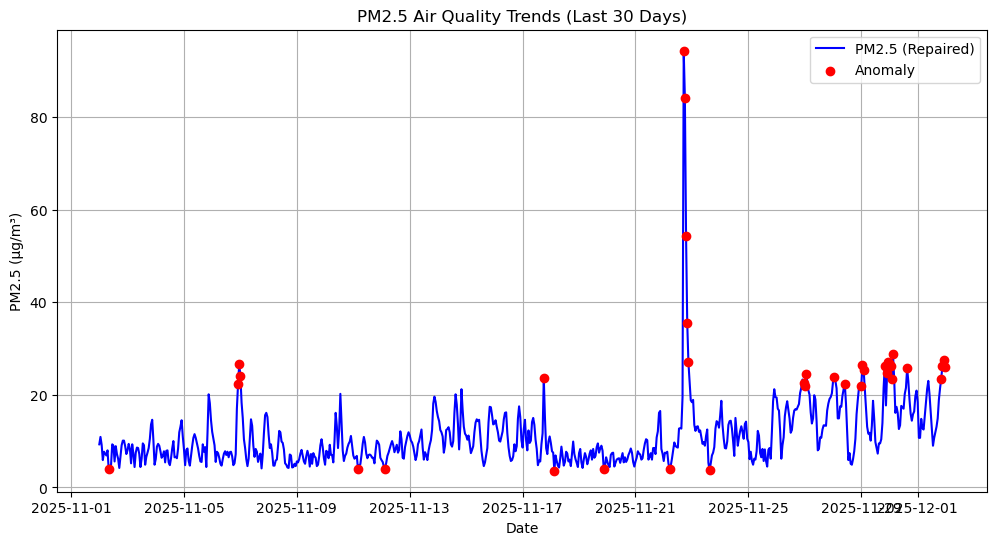

'I have generated the PM2.5 trend graph for you.'

In [8]:
# Example Interactions
print("User: What is the current PM2.5?")
print(f"Bot: {bot.ask('What is the current PM2.5?')}\n")

print("User: Give me a summary.")
print(f"Bot: {bot.ask('Give me a summary.')}\n")

print("User: Show graph.")
bot.ask('Show graph')

In [ ]:
# Interactive Loop (Uncomment to run interactively)
# while True:
#     q = input("You: ")
#     if q.lower() == 'exit':
#         break
#     print(f"Bot: {bot.ask(q)}")